In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
#import statsmodels.api as sm
#import itertools as it
#from statsmodels.sandbox.stats.multicomp import multipletests
#from itertools import compress
from pyBedGraph import BedGraph
from pybedtools import BedTool
import scipy.stats
from scipy.stats import gaussian_kde as kde
from matplotlib.colors import Normalize
from matplotlib import cm

In [2]:
#### Define functions ####
def modLog(num, denom):
    if num==0 or denom==0:
        return 0
    else:
        return float(format(np.log2(num/denom), '.4f'))

def ShannonEnt(probList):
    """Compute entropy for a list of probabilities."""
    if sum(probList)!=1:  ## input is count or frequency instead of probability
        probList = [i/sum(probList) for i in probList]
    entropy = sum([x*modLog(1,x) for x in probList])
    return float(format(entropy, '.6f'))

def normShannonEnt(probList):
    """Compute normalized entropy for a list of probabilities."""
    if sum(probList) != 1:   ## input is count or frequency instead of probability
        probList = [i/sum(probList) for i in probList]
    entropy = sum([x*modLog(1,x) for x in probList])/np.log2(len(probList))
    if len(probList) == 1:
        entropy = 0
    return float(format(entropy, '.6f'))

def KLdiv(p, q):
    """Compute KL divergence for two distributions p and q."""
    if sum(p)!=1:
        p = [i/sum(p) for i in p]
    if sum(q)!=1:
        q = [i/sum(q) for i in q]
    div = 0
    for i in range(0,len(p)):
        div = div + p[i]*modLog(p[i], q[i])
    return float(format(div, '.6f'))

def JSdiv(p, q):
    """Compute KL divergence for two distributions p and q."""
    if sum(p)!=1:
        p = [i/sum(p) for i in p]
    if sum(q)!=1:
        q = [i/sum(q) for i in q]
    #print(p)
    #print(q)
    m = [(p[i]+q[i])/2 for i in range(len(p))]
    #print(m)
    div = KLdiv(p, m)/2 + KLdiv(q, m)/2
    return float(format(div, '.6f'))

In [3]:
def read_cf(directory, file_name):
    with open(directory + file_name) as f:
        chrom = {}
        for line in f:
            tmp = line.strip().split("\t")
            if tmp[0] != 'chrM':
                chrom[tmp[0]] = int(tmp[1])
    return chrom

In [4]:
def read_peaks(directory, file_name):
    with open(directory + file_name) as f:
        bed = {}
        for line in f:
            tmp = line.strip().split("\t")
            lpid = tmp[3]+";"+tmp[4]+','+tmp[5]
            pklen = int(tmp[8])-int(tmp[7])
            #print(tmp)
            if tmp[6] != ".":
                nipbl = int(tmp[9])
                wapl = int(tmp[10])
            else:
                nipbl = "."
                wapl = "."
                pklen = -1
            if lpid in bed.keys():
                bed[lpid].append([pklen, nipbl, wapl]) # peak length, nipbl binding, wapl binding
            else:
                bed[lpid] = [[pklen, nipbl, wapl]]
    return bed

In [5]:
def read_allresult(directory, file_name):
    with open(directory + file_name) as f:
        alllist = []
        for line in f:
            tmp = line.strip().split("\t")
            if tmp[0] != 'LoopID':
                alllist.append([tmp[0], int(tmp[3]), int(tmp[7]), int(tmp[11]), tmp[22], tmp[23]])
    return alllist

In [6]:
def read_crnresult(directory, file_name):
    with open(directory + file_name) as f:
        crnlist = []
        next(f)
        for line in f:
            tmp = line.strip().split("\t")
            for i in range(4,9):
                tmp[i] = int(tmp[i])
            crnlist.append(tmp)
    return crnlist

In [7]:
def read_loops(directory, file_name):
    with open(directory + file_name) as f:
        loops = {}
        for line in f:
            tmp = line.strip().split("\t")
            loops[tmp[11]+';'+tmp[15]+','+tmp[20]] = [[tmp[12], int(tmp[13]), int(tmp[14]), tmp[15], 'lanchr']]
            loops[tmp[11]+';'+tmp[15]+','+tmp[20]].append([tmp[17], int(tmp[18]), int(tmp[19]), tmp[20], 'ranchr'])
    return loops

In [8]:
def plot_boxplot(dataset, dlabel, clr, tit, ylab, fig_name):
    fig = plt.figure(figsize = (8,6))
    medianprops = dict(linewidth = 3, color=clr)
    i=0
    boxprops = dict(linewidth = 1.5)
    toplot = [np.asarray([]) for i in range(len(dataset))]
    for d in dataset:
        #medianprops = dict(linewidth = 3, color=colcode[i])
        datax = toplot
        datax[i] = np.asarray(dataset[i])
        plt.boxplot(datax, widths = 0.6, medianprops = medianprops, boxprops = boxprops)
        i +=1
    plt.xticks([i for i in range(1, len(dataset)+1)], dlabel, fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.ylabel(ylab, fontsize = 18)
    #plt.ylim(bottom=2.5)
    #plt.ylim(top=3.0)
    plt.title(tit, fontsize = 18)
    plt.savefig(fig_name+'.pdf', dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()

In [9]:
def plot_3hist(x1, x2, x3, bin_lims, lab1, lab2, lab3, clr1, clr2, clr3, tit, xlab, fig_name):
    bin_centers = 0.5*(bin_lims[:-1]+bin_lims[1:])
    bin_widths = bin_lims[1:]-bin_lims[:-1]
    hist1, _ = np.histogram(x1, bins=bin_lims)
    hist2, _ = np.histogram(x2, bins=bin_lims)
    hist3, _ = np.histogram(x3, bins=bin_lims)
    
    ##normalizing
    hist1b = hist1/np.max(hist1)
    hist2b = hist2/np.max(hist2)
    hist3b = hist3/np.max(hist3)

    fig, (ax2) = plt.subplots(nrows = 1, ncols = 1, figsize=(8, 6))

    ax2.bar(bin_centers, hist1b, width = bin_widths, align = 'center', label = lab1, color = clr1, alpha = 0.2)
    ax2.bar(bin_centers, hist2b, width = bin_widths, align = 'center', label = lab2, color = clr2, alpha = 0.2)
    ax2.bar(bin_centers, hist3b, width = bin_widths, align = 'center', label = lab3, color = clr3, alpha = 0.2)
    ax2.legend(loc = 'upper right', fontsize = 18)    
    plt.title(tit, fontsize = 18)
    plt.xlabel(xlab, fontsize = 18)
    plt.ylabel("Relative Proportion", fontsize = 18)
    #plt.savefig(fig_name+'.pdf', dpi=300)
    plt.show()

In [10]:
def makeColours( vals ):
    colours = np.zeros( (len(vals),3) )
    norm = Normalize( vmin=vals.min(), vmax=vals.max() )

    #Can put any colormap you like here.
    colours = [cm.ScalarMappable( norm=norm, cmap='jet').to_rgba( val ) for val in vals]

    return colours

In [11]:
def plotscatter(x1,x2,  tit, xlab, ylab, fig_name):
    samples = np.array([x1, x2])
    densObj = kde( samples )
    colours = makeColours( densObj.evaluate( samples ) )
    plt.figure(figsize=(7,7))
    plt.scatter( samples[0], samples[1], color=colours , alpha = 0.5, edgecolors='none')
    plt.xlabel(xlab, fontsize=16)
    plt.ylabel(ylab, fontsize=16)
    plt.tick_params(axis='both', labelsize=14)
    pearson = round(scipy.stats.pearsonr(x1, x2)[0], 2)
    spearman = round(scipy.stats.spearmanr(x1, x2)[0], 2)
    plt.title(tit+ "\n Pearson = " + str(pearson)+", Spearman = " + str(spearman) + ", n="+str(len(x1)), fontsize=15)
    plt.savefig(fig_name + ".pdf", dpi=150)
    plt.show()

In [12]:
def get_cov(interval_list, bgobj):
    tmpvals = []
    for x in interval_list:
        if x[0] != 'chrM':
            value = list(bgobj.stats(stat = 'max', intervals = [x]))
            tmpvals.append(max(0, value[0]))
    return tmpvals

In [13]:
def write_result(directory, out_list, out_name):
    with open(directory+out_name, 'a') as file1:
        for i in range(len(out_list)):
            file1.write('\t'.join(map(str, out_list[i])) + '\n')
    file1.close()

In [14]:
directory='/Users/kimm/Desktop/GM12878_files/'
ctcfloop_allist='GM12878-CTCF-pooled_comp_FDR_0.2_PASS_motifext4kbboth_loops_AllResults.txt'
cohesinloop_allist='GM12878-cohesin-pooled_comp_FDR_0.2_PASS_motifext4kbboth_loops_AllResults.txt'
loopfile = 'LHG0052H.e500.clusters.cis.bothanchint_G250.PETcnt_G9.motifannot.sorted.loops'
wapl_cov='CHG0032.q30.nr.sorted.bedgraph'
nipbl_cov='CHG0030.q30.nr.sorted.bedgraph'
nipbl_peaks='LHG0052H.loops.intersect.CHG0030peaks-annot-nipbl-wapl.bed'

In [15]:
chromfile = read_cf(directory, 'hg38.chrom.sizes')

In [16]:
bgwapl = BedGraph(directory+'hg38.chrom.sizes', directory+wapl_cov)
bgnipbl = BedGraph(directory+'hg38.chrom.sizes', directory+nipbl_cov)

In [17]:
for key,val in chromfile.items():
    bgwapl.load_chrom_data(key)
    bgnipbl.load_chrom_data(key)

In [18]:
peaks = read_peaks(directory, nipbl_peaks)

In [19]:
loopannot = read_loops(directory, loopfile)

In [20]:
ctcfloop = read_allresult(directory, ctcfloop_allist)
cohesinloop = read_allresult(directory, cohesinloop_allist)

In [21]:
loops = {}
for x in ctcfloop:
    if x[4] != '.' and x[5] != '.':
        loops[x[0]+";"+x[4]+","+x[5]] = [[x[1], x[2], x[3]]]

In [22]:
for x in cohesinloop:
    if x[4] != '.' and x[5] != '.':
        loops[x[0]+";"+x[4]+","+x[5]].append([x[1], x[2], x[3]])

In [23]:
len(loopannot)

13549

In [25]:
len(loops)

10214

In [28]:
for key, val in loops.items():
    #print(key)
    #print(loopannot[key])
    bed = [loopannot[key][0][0:3], loopannot[key][1][0:3]]
    bed[0][1] -= 4000
    bed[0][2] += 4000
    bed[1][1] -= 4000
    bed[1][2] += 4000
    nipbl_vals = get_cov(bed, bgnipbl)
    wapl_vals = get_cov(bed, bgwapl)
    loops[key].append(nipbl_vals)
    loops[key].append(wapl_vals)
    loops[key].append([len([x for x in peaks[key] if x[0]!=-1]), sum([x[1] for x in peaks[key] if x[0]!=-1]), sum([x[1]*x[0] for x in peaks[key] if x[0]!=-1])])
    loops[key].append(bed[0][0]+":"+str(bed[0][1])+"-"+str(bed[1][2]))

In [43]:
towrite = [['loopid', 'motiforient', 'ctcf_left', 'ctcf_right', 'ctcf_both', 'cohesin_left', 'cohesin_right', 'cohesin_both', 'nipbl_left', 'nipbl_right', 'wapl_left', 'wapl_right','nipbl_num', 'nipbl_tot', 'nipbl_tot-len','region', 'ctcf_tot', 'ctcf_left_per', 'ctcf_right_per', 'ctcf_both_per', 'cohesin_tot', 'cohesin_left_per', 'cohesin_right_per', 'cohesin_both_per', 'nipbl/wapl_left', 'nipbl/wapl_right']]
for key, val in loops.items():
    tmp = [key.split(";")[0]]
    tmp.append(key.split(";")[1])
    tmp.extend(val[0])
    tmp.extend(val[1])
    tmp.extend(val[2])
    tmp.extend(val[3])
    tmp.extend(val[4])
    tmp.append(val[5])
    tmp.append(sum(val[0]))
    tmp.extend([round(x*100/max(1,sum(val[0])), 3) for x in val[0]])
    tmp.append(sum(val[1]))
    tmp.extend([round(x*100/max(1, sum(val[1])), 3) for x in val[1]])
    tmp.append(round(val[2][0]/val[3][0], 2))
    tmp.append(round(val[2][1]/val[3][1], 2))
    towrite.append(tmp)

In [45]:
for i in range(len(towrite[0])):
    print(str(i) + ": " + towrite[0][i])

0: loopid
1: motiforient
2: ctcf_left
3: ctcf_right
4: ctcf_both
5: cohesin_left
6: cohesin_right
7: cohesin_both
8: nipbl_left
9: nipbl_right
10: wapl_left
11: wapl_right
12: nipbl_num
13: nipbl_tot
14: nipbl_tot-len
15: region
16: ctcf_tot
17: ctcf_left_per
18: ctcf_right_per
19: ctcf_both_per
20: cohesin_tot
21: cohesin_left_per
22: cohesin_right_per
23: cohesin_both_per
24: nipbl/wapl_left
25: nipbl/wapl_right


In [46]:
len(towrite[1])

26

In [69]:
write_result(directory, towrite, 'CTCF-cohesin-loops-nipbl-wapl-v2_20200724.txt')

In [47]:
conv_loops = [x for x in towrite if x[1] == '+,-' and x[16]> 50 and x[20]>100]
rtan_loops = [x for x in towrite if x[1] == '+,+' and x[16]> 50 and x[20]>100]
ltan_loops = [x for x in towrite if x[1] == '-,-' and x[16]> 50 and x[20]>100]
div_loops = [x for x in towrite if x[1] == '-,+' and x[16]> 50 and x[20]>100]

In [50]:
x0 = [x[21]*100/(x[21]+x[22]) for x in conv_loops] # left/(left+right) complexes
x1 = [x[10]*100/(x[10]+x[11]) for x in conv_loops] # WAPL left/(left+right)
x2 = [x[12] for x in conv_loops] # nipbl number
#x3 = [x[13] for x in conv_loops] # nipbl tot
x3 = [x[13] for x in conv_loops if x[23]<30] # nipbl tot
x4 = [x[14] for x in conv_loops] # nipbl tot times length
x5 = [x[19] for x in conv_loops] # percentage of both in CTCF
#x6 = [x[23] for x in conv_loops] # percentage of both in cohesin
x6 = [x[23] for x in conv_loops if x[23]<30] # percentage of both in cohesin
x7 = [x[13] for x in conv_loops if x[23] >= 5] # nipbl tot if cohesin both % > 5
x8 = [x[13] for x in conv_loops if x[23] < 5] # nipbl tot if cohesin both % < 5

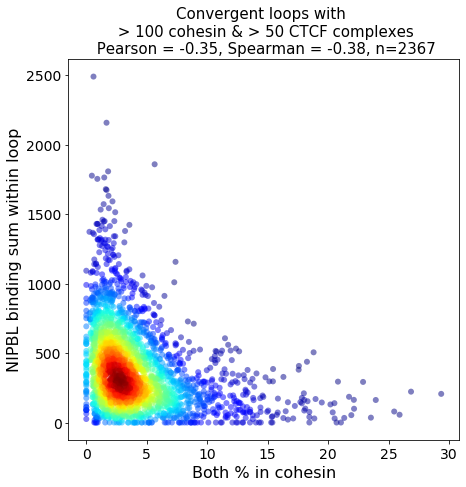

In [51]:
plotscatter(x6, x3,  "Convergent loops with \n > 100 cohesin & > 50 CTCF complexes",'Both % in cohesin', 'NIPBL binding sum within loop', 'convergent_loops_cohesin_high-both_vs_low-both_nipbl_binding_sum_scatterplot_LE30_20200902')

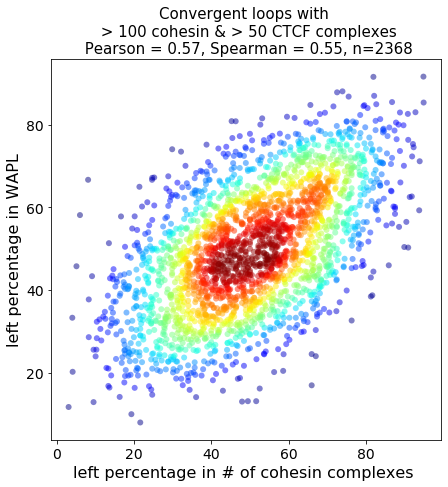

In [210]:
plotscatter(x0, x1,  "Convergent loops with \n > 100 cohesin & > 50 CTCF complexes", 'left percentage in # of cohesin complexes ', 'left percentage in WAPL', 'convergent_loops_complexes_vs_waplbinding_scatterplot_20200724')